<center>

--- 

# Proyecto Ciencia de Datos
## Clasificación de señales EEG de Neuroimaginería Motora en pacientes con alta incertidumbre mediante un Transformer Espectral
### Jorge de la Rosa, Alejandro del Río
### Grado en Ciencia de Datos e Inteligencia Artificial
<img src=https://www.upm.es/sfs/Rectorado/Gabinete%20del%20Rector/Logos/UPM/Logotipo%20con%20Leyenda/LOGOTIPO%20leyenda%20color%20PNG.png width=25% height=25%>

---
</center>

**Descripción:** El objetivo de este proyecto es estudiar la posibilidad de emplear un [transformer espectral](https://www.sciencedirect.com/science/article/abs/pii/S1746809423005633) para clasificar señales de neuroimaginería motora en pacientes donde los métodos clásicos usados (CSP-LDA) no obtienen buenos resultados en entornos con datos escasos.

**Nota:** El dataset EEGBCI empleado en el estudio se encuentra en la página de [PhysioNet](https://www.physionet.org/content/eegmmidb/1.0.0/). Este dataset se encuentra dentro de la propia libreria de MNE. Hay varias funciones repetidas a lo largo del notebook. Las funciones importantes se presentan su código la primera vez, y luego se emplean mediante el módulo *utils.py* por simplificación de código.

#### Importación de librerías

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mne
import seaborn as sns
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.model_selection import ShuffleSplit, cross_val_score
from sklearn.model_selection import train_test_split
from scipy import stats
from mne import Epochs, pick_types, events_from_annotations
from tensorflow.keras.losses import categorical_crossentropy
from mne.channels import make_standard_montage
from mne.io import concatenate_raws, read_raw_edf
from mne.datasets import eegbci
from mne.decoding import CSP
from tqdm import tqdm
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from scipy.signal import welch
from sklearn.metrics import (
    accuracy_score,
    classification_report,
    confusion_matrix,
    precision_score,
    recall_score,
    f1_score
)


from tensorflow.keras import layers, regularizers
from tensorflow.keras.callbacks import EarlyStopping
import numpy as np
import plotly.graph_objs as go
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
from sklearn.metrics import accuracy_score
import plotly.express as px
mne.set_log_level('CRITICAL')
from itertools import combinations

%matplotlib inline

import warnings
warnings.filterwarnings("ignore")

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
sns.set(style="ticks")

from utils import (
    index_below_threshold,
    display_descriptive_statistics,
    evaluate_and_visualize,
    extract_motor_imagery_data,
    load_eeg_data,
    split_eeg_data,
    classify_individual_subjects,
    visualize_csp_components,
    get_BCI_competition_data,
    evaluate_classification_metrics
)

from models import create_ATCNet, create_spectral_transformer_model

### Carga de datos

**Extracción de datos para un sujeto dado:**
Comenzamos cargando los datos del sujeto Nº1. Las sesiones empleadas son las 6, 10 y 14, las cuales contienen registros de neuroimaginería motora de manos y pies.

In [2]:
# Definir parámetros
tmin, tmax = -1.0, 4.0
event_id = dict(hands=2, feet=3) # motor imagery: hands vs feet
runs = [6, 10, 14]  # Runs donde estan manos y pies imagineria
subject = 1

# Cargar datos EEG y concatenar sesiones
raw_fnames = eegbci.load_data(subject, runs)
raw = concatenate_raws([read_raw_edf(f, preload=True) for f in raw_fnames])
    
# Estandarizar los canales
eegbci.standardize(raw)
    
# Aplicar montaje estándar (10-10 system)
montage = make_standard_montage("standard_1005")
raw.set_montage(montage)

# Aplicar filtro pasa bandas
# Nota: Para funciones de NeuroImanieria el rango de frecuencias se encuentran entre 7 Hz a 30 Hz
raw.filter(7.0, 30.0, fir_design="firwin", skip_by_annotation="edge")

# Obtener eventos y picks
events, _ = events_from_annotations(raw, event_id=dict(T1=2, T2=3))
picks = pick_types(raw.info, meg=False, eeg=True, stim=False, eog=False, exclude="bads")

# Leer épocas (entrenamiento entre 1 y 2 segundos despues del evento)
epochs = Epochs(
    raw,
    events,
    event_id,
    tmin,
    tmax,
    proj=True,
    picks=picks,
    baseline=None,
    preload=True,)

epochs_train = epochs.copy().crop(tmin=1.0, tmax=2.0)
labels = epochs.events[:, -1] - 2
raw

<RawEDF | S001R06.edf, 64 x 60000 (375.0 s), ~29.4 MB, data loaded>

#### Análisis de los datos:

Comenzamos visualizando el montaje del sistema internacional 10-10 empleado para la captura de las señales EEG.

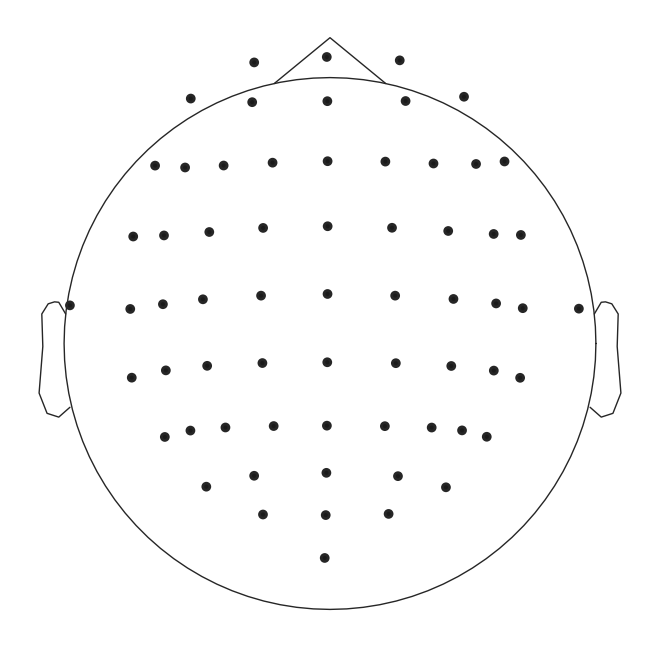

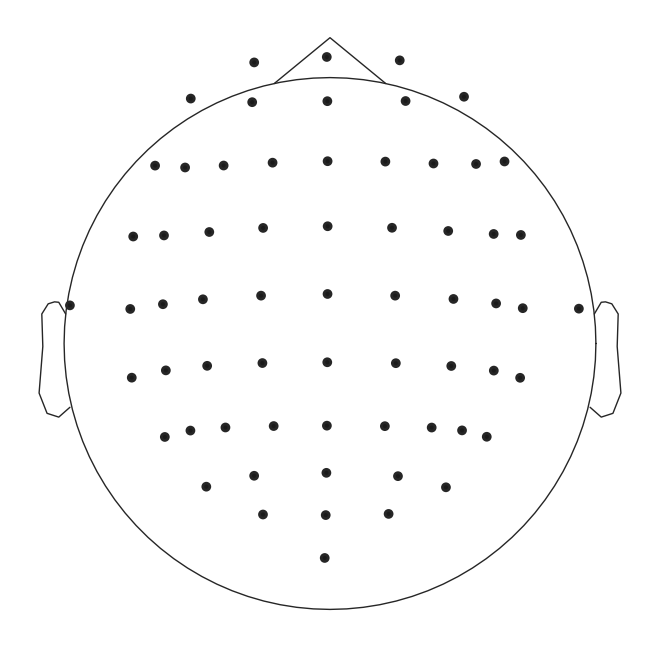

In [3]:
raw.plot_sensors()

Veamos un pequeño segmento de la señal EEG para el canal FP1. La muestra ha sido recortada a solo 6 segundos para una mejor visualización.

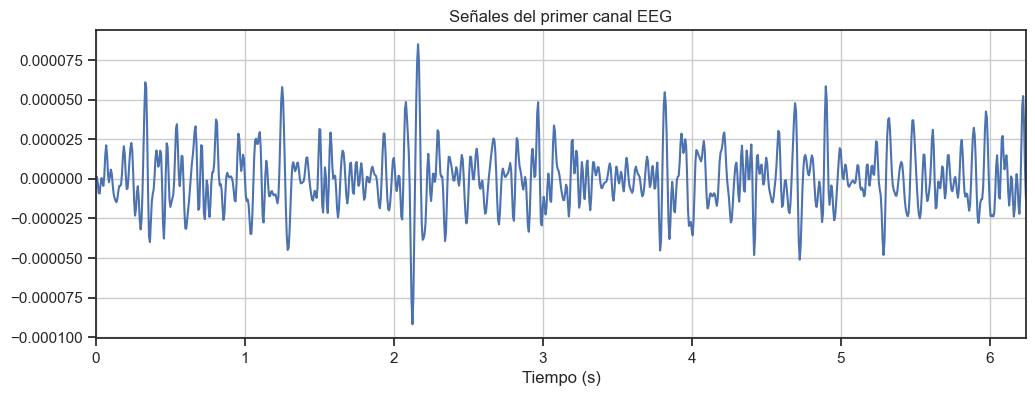

In [4]:
idx_channel = 0
n_samples = 1000
fs = 160
X = raw._data[idx_channel][:n_samples]
t = np.arange(X.shape[0]) / fs

plt.figure(figsize=(12, 4))
plt.plot(t, X)
plt.xlabel('Tiempo (s)')
plt.grid()
plt.title('Señales del primer canal EEG')
plt.xlim([t[0], t[-1]])
plt.show()

Se procede a visualizar el conjunto de señales mediante el uso del *Power Signal Density* para obtener una visualización del filtrado de 7 Hz a 30 Hz. Es en este rango de frecuencias donde se encuentran contenidas los impulsos motores del cuerpo humano.

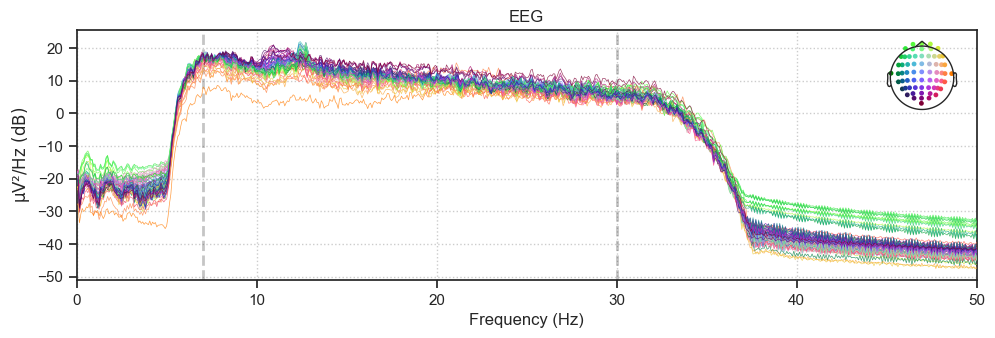

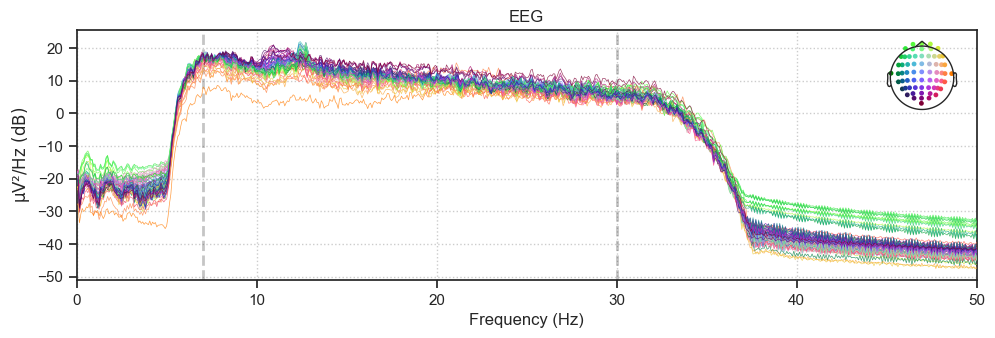

In [5]:
raw.compute_psd(fmax=50).plot(picks="data", exclude="bads")
# Se ve el filtrado de 7hz a 30hz

El efecto del uso del filtro de paso banda en la señal se puede ver con el siguiente espectrograma.

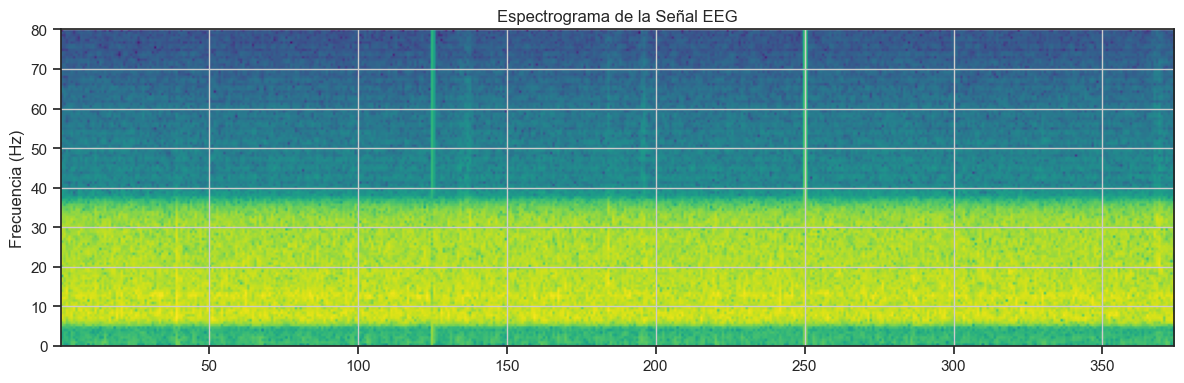

In [6]:
data_original = raw.copy().get_data()[0]

# Crear la figura y los ejes
fig, ax1 = plt.subplots(figsize=(12, 4))

# Plotea el espectrograma de la señal original sin filtrar
ax1.specgram(data_original, Fs=raw.info['sfreq'], cmap='viridis')
ax1.set_title('Espectrograma de la Señal EEG')
ax1.set_ylabel('Frecuencia (Hz)')
ax1.grid()

# Ajusta el diseño de la figura y muestra la visualización
plt.tight_layout()
plt.show()

plt.show()

Se aplica un Common Spatial Patterns (CSP) para obtener las 4 componentes principales de los datos. De esta forma podemos visualizar las 4 componentes y las áreas de mayor actividad en la tarea asignada para el sujeto Nº1.

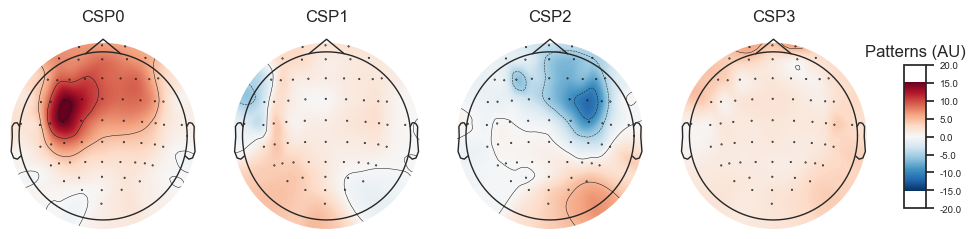

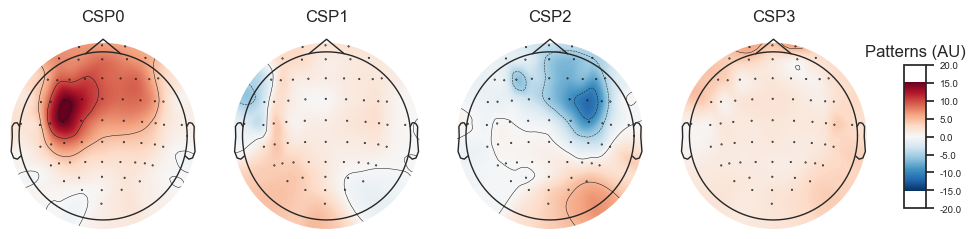

In [7]:
epochs_data = epochs.get_data()
epochs_data_train = epochs_train.get_data()

csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)

# plot CSP patterns estimated on full data for visualization
csp.fit_transform(epochs_data, labels)
csp.plot_patterns(epochs.info, ch_type="eeg", units="Patterns (AU)", size=1.5)

Se puede visualizar con mayor precisión las componentes obtenidas por el CSP.

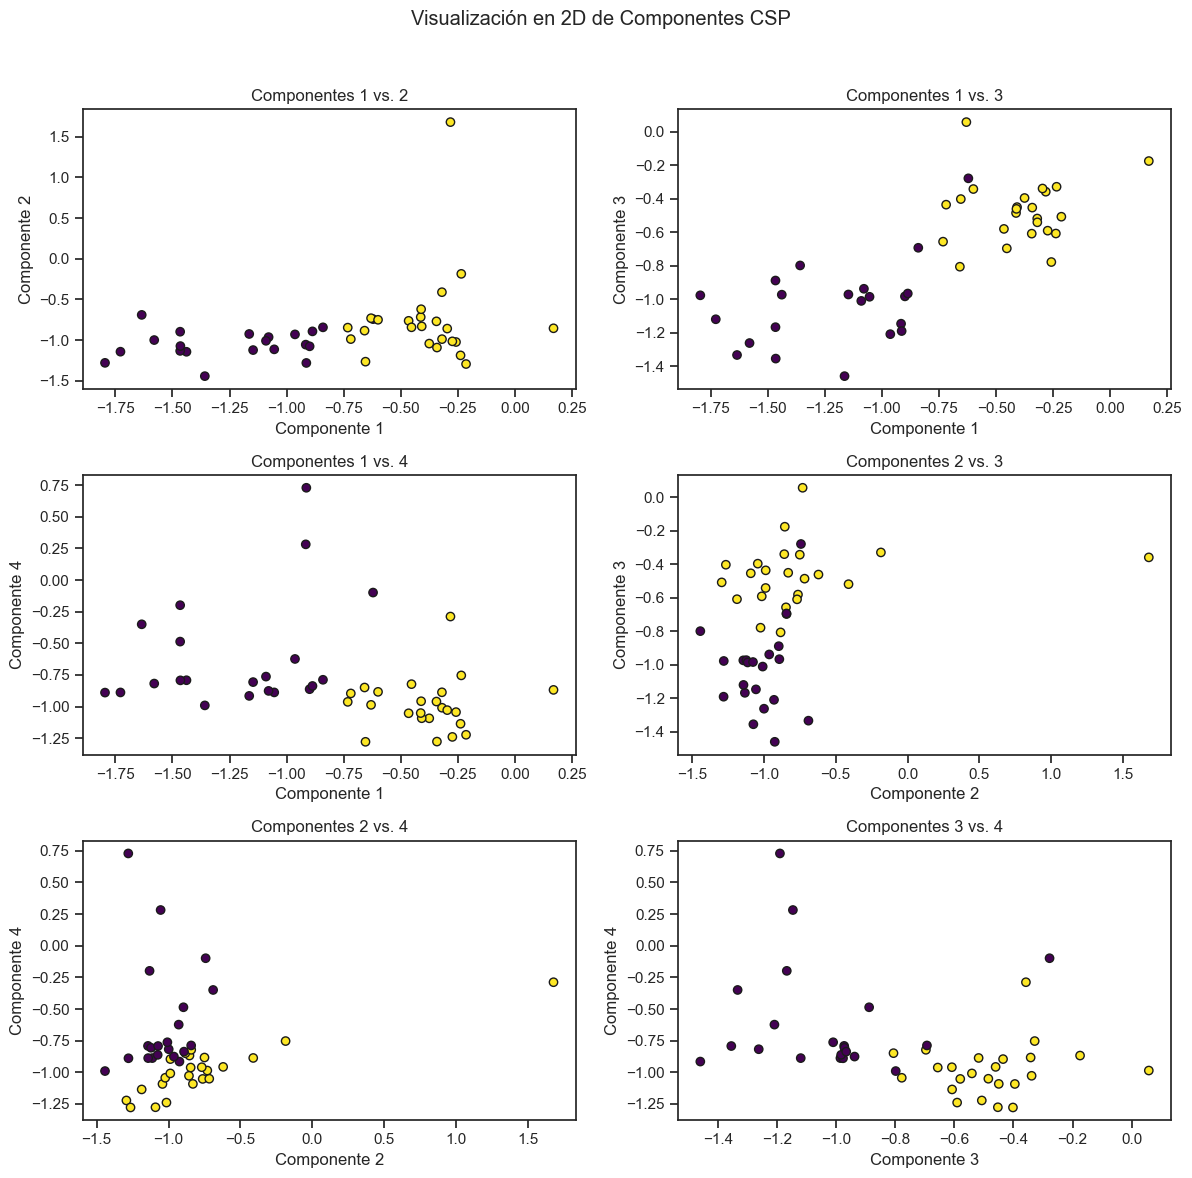

In [8]:
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)

# plot CSP patterns estimated on full data for visualization
X_train_reshaped_csp = csp.fit_transform(epochs_data, labels)

# Obtener todas las combinaciones posibles de dos componentes
combinations_2d = list(combinations(range(X_train_reshaped_csp.shape[1]), 2))

# Crear subgráficos
fig, axes = plt.subplots(nrows=len(combinations_2d)//2, ncols=2, figsize=(12, 12))
fig.suptitle('Visualización en 2D de Componentes CSP')

# Visualizar cada combinación en un gráfico 2D
for i, (component1, component2) in enumerate(combinations_2d):
    ax = axes[i // 2, i % 2]
    ax.scatter(X_train_reshaped_csp[:, component1], X_train_reshaped_csp[:, component2], c=labels, cmap='viridis', marker='o', edgecolors='k')
    ax.set_xlabel(f'Componente {component1 + 1}')
    ax.set_ylabel(f'Componente {component2 + 1}')
    ax.set_title(f'Componentes {component1 + 1} vs. {component2 + 1}')

# Ajustar el diseño y mostrar los gráficos
plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

### Fase de Modelado

Para la fase de modelado, vamos a probar diferentes métodos para realizar una clasificación general de todas las señales de todos los sujetos. En total, tenemos 109 sujetos con 45 muestras por cada uno aproximadamente.

In [10]:
# Cargamos los datos de todos los sujetos
# Datos no estandarizados
X_train_reshaped, y_train, X_test_reshaped, y_test = split_eeg_data(standardize=False)
# Datos estandarizados
X_train_reshaped_std, _, X_test_reshaped_std, _ = split_eeg_data(standardize=True)


100%|██████████| 109/109 [01:20<00:00,  1.35it/s]


In [11]:
# Imprime las formas para verificar
print("Forma de X_train_reshaped:", X_train_reshaped.shape)
print("Forma de X_test_reshaped:", X_test_reshaped.shape)
print("Forma de X_train_reshaped_std:", X_train_reshaped_std.shape)
print("Forma de X_test_reshaped_std:", X_test_reshaped_std.shape)
print("Forma de y_train:", y_train.shape)
print("Forma de y_test:", y_test.shape)

Forma de X_train_reshaped: (4272, 64, 161)
Forma de X_test_reshaped: (475, 64, 161)
Forma de X_train_reshaped_std: (4272, 64, 161)
Forma de X_test_reshaped_std: (475, 64, 161)
Forma de y_train: (4272,)
Forma de y_test: (475,)


#### **Machine Learning:** Common Spatial Pattern - Linear Discriminant Analysis (CSP-LDA)

Probamos primero con las técnicas clásicas utilizadas en la literatura.

In [13]:
csp = CSP(n_components=4, reg=None, log=True, norm_trace=False)
lda = LinearDiscriminantAnalysis()

In [14]:
X_train_reshaped_csp = csp.fit_transform(X_train_reshaped, y_train)
X_test_reshaped_csp  = csp.transform(X_test_reshaped)

((4272, 4), (475, 4))

In [16]:
# Entrenamos el modelo
lda.fit(X_train_reshaped_csp, y_train)

# Predicciones en el conjunto de prueba
y_pred = lda.predict(X_test_reshaped_csp)

accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Otras métricas y matriz de confusión
print(classification_report(y_test, y_pred))
print(confusion_matrix(y_test, y_pred))

Accuracy: 0.6463157894736842
              precision    recall  f1-score   support

           0       0.62      0.69      0.65       230
           1       0.67      0.61      0.64       245

    accuracy                           0.65       475
   macro avg       0.65      0.65      0.65       475
weighted avg       0.65      0.65      0.65       475

[[158  72]
 [ 96 149]]


#### **Deep Learning:** Convolutional Neural Networks (CNNs) y Neural Networks (NNs)

##### Experimento 1: CNN

In [12]:
# Construir el modelo CNN
model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(64, 161, 1)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(64, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compilar el modelo
model.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 159, 32)       320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 79, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 77, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 38, 64)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 34048)             0         
                                                                 
 dense (Dense)               (None, 64)                2

Sin estandarización:

In [ ]:
# Entrenar el modelo y almacenar el historial
history = model.fit(X_train_reshaped, y_train, epochs=30, validation_data=(X_test_reshaped, y_test))
evaluate_and_visualize(model, history, X_test_reshaped, y_test)

Con estandarización:

In [ ]:
# Entrenar el modelo y almacenar el historial
history = model.fit(X_train_reshaped_std, y_train, epochs=30, validation_data=(X_test_reshaped_std, y_test))
evaluate_and_visualize(model, history, X_test_reshaped_std, y_test)

##### Experimento 2: NN-CSP

In [ ]:
n_csp_components = 4

# Construir el modelo NN
model = Sequential()
model.add(Dense(30, activation='relu', input_shape=(n_csp_components,)))
model.add(Dense(30, activation='relu'))
model.add(Dense(1, activation='sigmoid'))

# Compilar el modelo
model.compile(optimizer=Adam(), loss=BinaryCrossentropy(), metrics=['accuracy'])
model.summary()

Sin estandarización:

In [ ]:
csp = CSP(n_components=n_csp_components, reg=None, log=True, norm_trace=False)
X_train_reshaped_csp = csp.fit_transform(X_train_reshaped, y_train)
X_test_reshaped_csp  = csp.transform(X_test_reshaped)
history = model.fit(X_train_reshaped_csp, y_train, epochs=30, validation_data=(X_test_reshaped_csp, y_test))
evaluate_and_visualize(model, history, X_test_reshaped_csp, y_test)

Con estandarización:

In [ ]:
csp = CSP(n_components=n_csp_components, reg=None, log=True, norm_trace=False)
X_train_reshaped_csp_std = csp.fit_transform(X_train_reshaped_std, y_train)
X_test_reshaped_csp_std  = csp.transform(X_test_reshaped_std)
history = model.fit(X_train_reshaped_csp_std, y_train, epochs=30, validation_data=(X_test_reshaped_csp_std, y_test))
evaluate_and_visualize(model, history, X_test_reshaped_csp_std, y_test)

### Análisis de resultados

Como podemos observar, los modelos empleados en la fase de modelado no consiguen resultados decentes. En general, todos los modelos empleados tienen un *accuracy* en torno al $60\%$, tan solo un $10\%$ por encima del $50\%$ que se obtiene de predecir aleatoriamente. En la siguiente visualización enseñamos el resultado del CSP aplicado a todos los sujetos a la vez.          

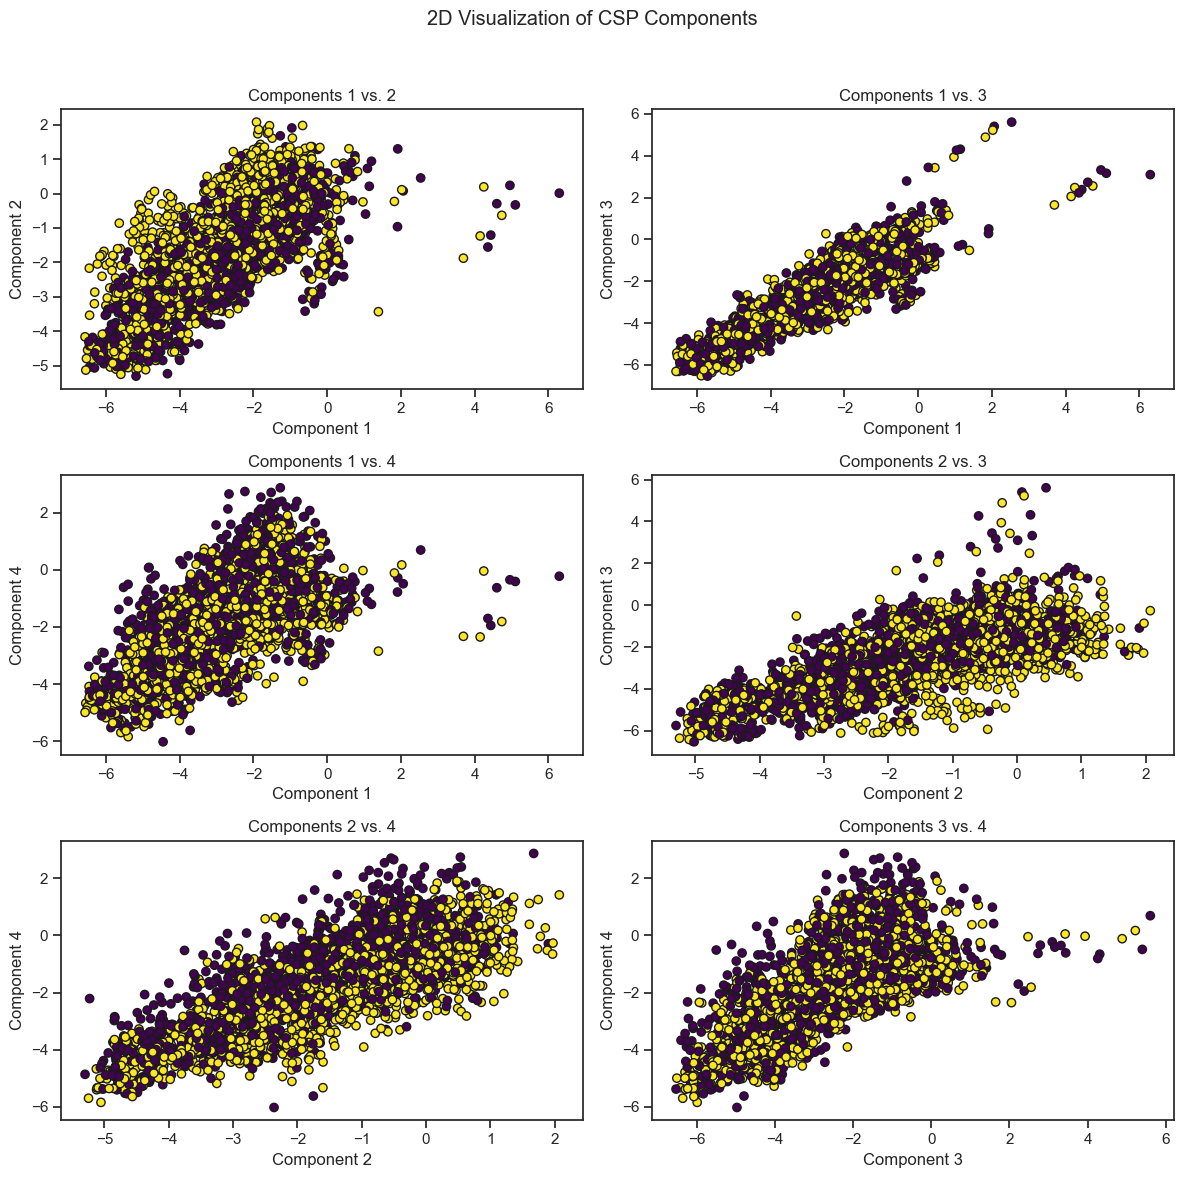

In [15]:
visualize_csp_components(X_train_reshaped, y_train, num_csp_components=4)

Como se puede observar en la figura anterior, los datos son prácticamente indivisibles. Esto dificulta, si no impide, la labor de los métodos usados para la clasificación de señales. Sin embargo, si empleamos las técnicas anteriormente usadas individualmente por sujeto, obtenemos buenos resultados para ciertos pacientes en concreto. Este tipo de técnica se denomina [*Subject-independent EEG classification*](https://www.frontiersin.org/articles/10.3389/fnins.2023.1124089/full).

100%|██████████| 109/109 [01:30<00:00,  1.21it/s]


# Subjects processed: 106 / 110  (96.36%)
Mean: 0.6377358490566037
Variance: 0.06876468494126024
Minimum: 0.0
Maximum: 1.0
Median: 0.6
Mode: 0.8


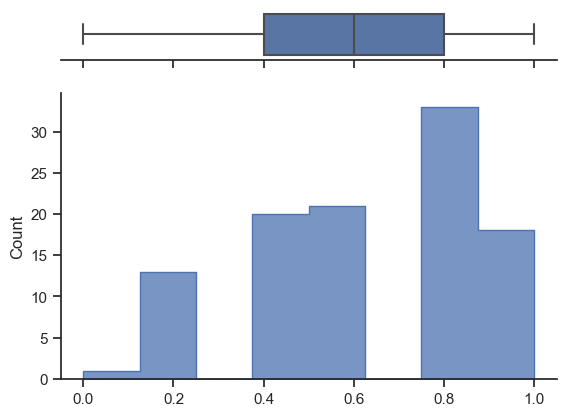

In [17]:
# Predicción con CSP-LDA
acc_results_csplda = classify_individual_subjects(use_lda=True)
idx_csplda = index_below_threshold(acc_results_csplda, threshold=0.6)
display_descriptive_statistics(acc_results_csplda)

In [ ]:
# Predicción con CSP-NN
acc_results_nn = classify_individual_subjects(use_lda=False)
idx_nn = index_below_threshold(acc_results_nn, threshold=0.6)
display_descriptive_statistics(acc_results_nn)

Podemos ver que no hay mucha diferencia entre aplicar LDA y una red neuronal a los datos obtenidos por hacer CSP. Debemos de destacar que predecir las clases aleatoriamente se debería obtener un en torno a un $50\%$. Sin embargo, hay bastantes sujetos donde los modelos dan por debajo de este umbral. Veamos una gráfica donde enseñamos los mejores resultados obtenidos por LDA y por la red neuronal.

Mean: 0.6905660377358489
Variance: 0.05972232111071554
Minimum: 0.2
Maximum: 1.0
Median: 0.8
Mode: 0.8


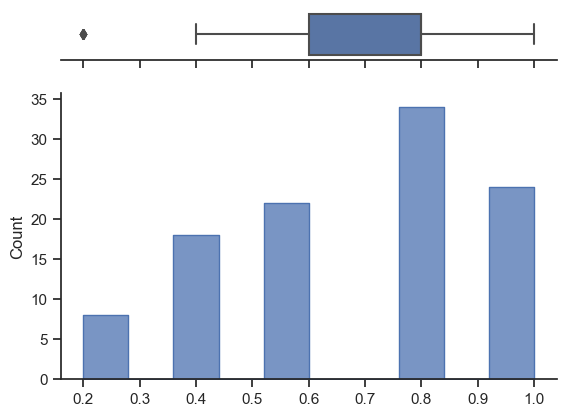

In [20]:
max_value = [max(csplda, nn) for csplda, nn in zip(acc_results_csplda, acc_results_nn)]
display_descriptive_statistics(max_value)

A continuación, vamos a ver el CSP obtenido de un sujeto donde no se ha conseguido buenos resultados ni usando LDA ni con una red neuronal.

Subject ID: 20   Best accuracy from both models:  0.2


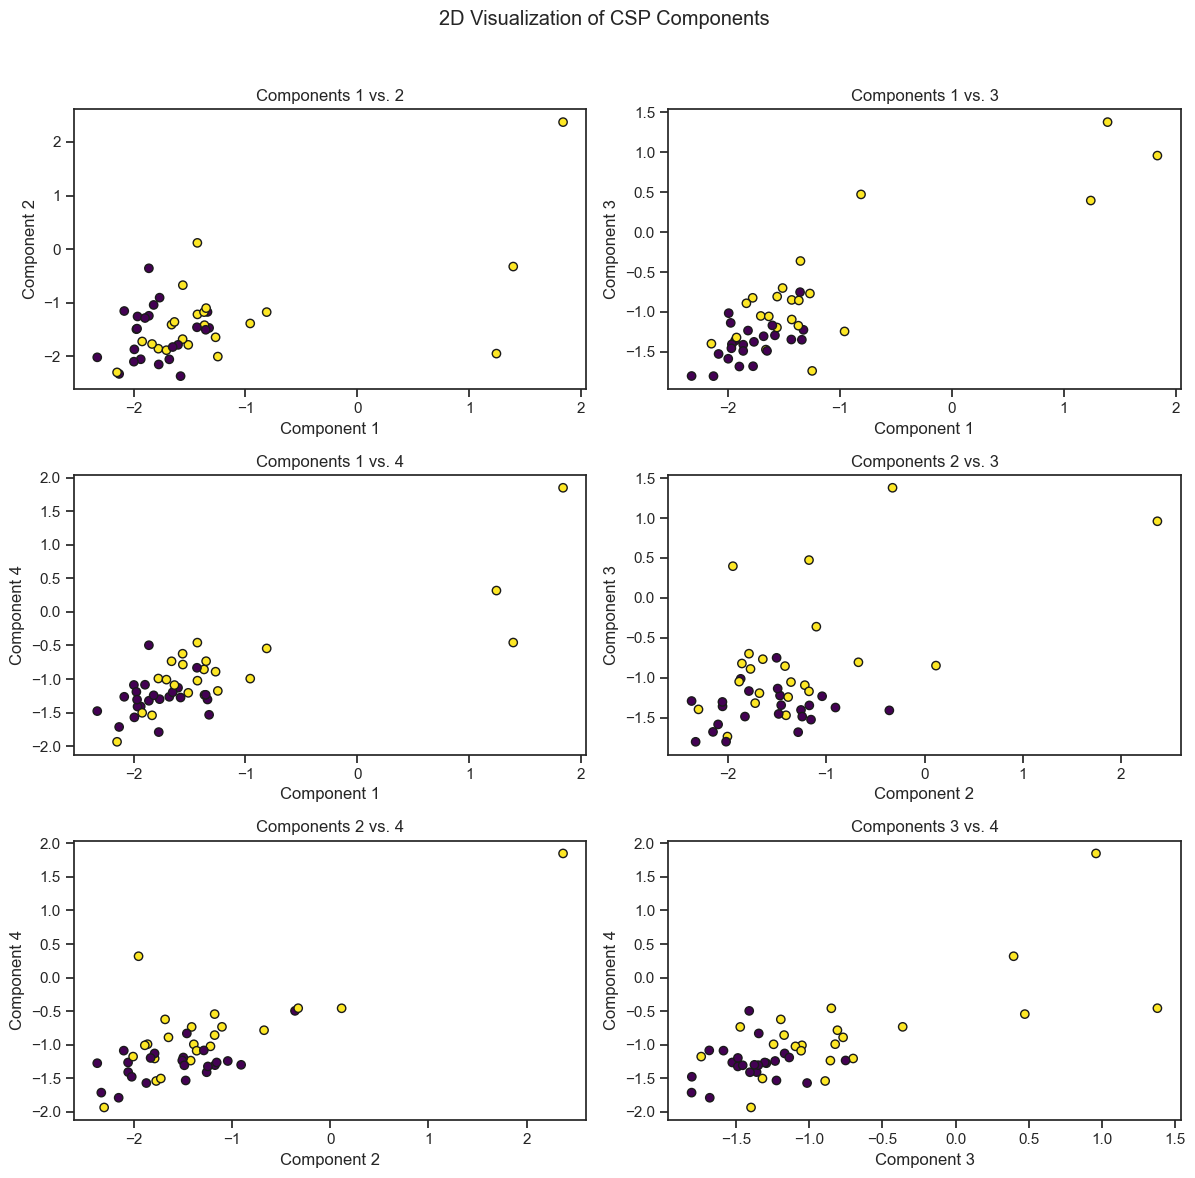

In [49]:
# vals = index_below_threshold(max_value, threshold=0.2)
vals = [(k + 1, v) for k, v in enumerate(max_value) if v <= 0.2]
id_bad_subject = vals[1][0]
epochs_train, all_labels = extract_motor_imagery_data(id_bad_subject)
all_data = epochs_train.get_data()
print(f'Subject ID: {vals[1][0]}   Best accuracy from both models:  {vals[1][1]}')
visualize_csp_components(all_data, all_labels, num_csp_components=4)


Como podemos ver, las muestras obtenidas en este tipo de pacientes es bastante difícil de distinguir, por estar bastante mezclados entre sí. Por ello, nuestro camino a seguir a continuación es estudiar la viabilidad de usar un transformer espectral preentrenado con todo el conjunto de datos de sujetos, y realizar un Fine-tuning en pacientes donde la distancia entre clases es bastante pequeña, con el objetivo de lograr una mejor predicción que los modelos anteriormente usados.

### Transformer Espectral

Para el transformer espectral, hemos usado la arquitectura diseñada en [este paper](https://www.sciencedirect.com/science/article/abs/pii/S1746809423005633) publicado el día 8 de junio de 2023. Para tener una métrica de referencia de la calidad de nuestro transformer espectral, vamos a compararlo con un transformer del estado del arte en clasificación de señales EEG motoras. Se trata de un modelo Attention Temporal Convolutional Network (ATCNet), publicado en [este paper](https://ieeexplore.ieee.org/document/9852687) publicado el 9 de agosto de 2022. En él, se emplea el dataset [BCI Competition IV-2a](https://lampx.tugraz.at/~bci/database/001-2014/description.pdf). Este dataset es usado frecuentemente para comparar modelos de clasificación de señales neuromotoras. Está desarrollado por la Graz University of Technology, en Austria. El dataset contiene archivos de 9 sujetos diferentes. Para cada sujeto se tiene 288 muestras de entrenamiento y 288 muestras de testeo. Sin embargo, la única diferencia entre este dataset y el empleado inicialmente reside en que se clasifican 4 clases, en vez de las 2 originarias.

#### Implementación

El transformer espectral emplea las señales en PSD como entrada del modelo. Una vez se a transformado la señal, se le suma un Positional Encoding. Luego, se pasa por una capa densa y se inserta en el encoding block. Finalmente, se pasa un Global Average Pooling y se pasa por una capa de clasificación. La estructura del Transformer se detalla en la siguiente imagen.

<figure>
    <img src="img/st.png" alt="Texto alternativo" style="width:200px; display:block; margin:auto; border:2px dashed #6495ED;" />
    <figcaption style="text-align:center; color:#6495ED; font-style:italic; font-size:18px;">Transformer Espectral</figcaption>
</figure>


Para el encoding block se emplea un Pre-LN Transformer. Esta variedad de transformer surge como solución para la estructura tradicional de Post-LN Transformer. Este tipo de transformer presentan una inestabilidad en los gradientes de la capa Multi-Head Attention, por lo que se requiere de realizar un Gradient Warmup para entrenar. Como solución, los Pre-LN Transformer cambian la ubicación de la capa de normalización y la colocan antes de la capa Multi-Head Attention. En la siguiente figura se detalla lo comentado: 

<figure>
    <img src="img/preln.png" alt="Texto alternativo" style="width:200px; display:block; margin:auto; border:2px dashed #6495ED;" />
    <figcaption style="text-align:center; color:#6495ED; font-style:italic; font-size:18px;">Pre-LN Transformer</figcaption>
</figure>

Definamos las funciones que vamos a utilizar para nuestro **transformer espectral** capa por capa. El modelo **ATCNet** se implementará en el archivo *models.py*. No lo mostramos en este notebook porque no era parte de nuestra línea de investigación principal, solo como forma de comparar nuestro modelo.

In [3]:
def calculate_psd(data, fs=250):
    """
    Calcula el espectro de potencia (PSD) para cada canal en cada muestra de un conjunto de datos EEG.

    Parameters:
    - data (numpy.ndarray): Datos EEG en formato (n_muestras, n_canales, n_muestras_por_canal).
    - fs (int): Frecuencia de muestreo en Hz.

    Returns:
    - result_data (numpy.ndarray): Array 3D que contiene los PSD calculados.
    """
    # Calcular la longitud de la ventana de Fourier
    size_signal = data.shape[2]
    nfft = 2**int(np.ceil(np.log2(size_signal)))

    # Inicializar una lista para almacenar los resultados del PSD
    result_data = []

    # Iterar sobre cada muestra en el conjunto de datos
    for i in tqdm(range(data.shape[0])):  
        # Inicializar una lista para almacenar los PSD de cada canal en la muestra
        list_psd = []

        # Iterar sobre cada canal en la muestra
        for j in range(data.shape[1]):  
            # Obtener los datos del canal actual
            channel_data = data[i, j, :]

            # Calcular el PSD utilizando la función welch de SciPy
            _, psd = welch(channel_data, fs=fs, nperseg=nfft, noverlap=0, nfft=nfft, scaling='density')

            # Agregar el PSD calculado a la lista
            list_psd.append(psd)

        # Agregar la lista de PSD de la muestra actual a los resultados
        result_data.append(list_psd)

    # Convertir los resultados a un array numpy y devolverlos
    return np.array(result_data)

In [13]:
class PreLNEncoder(layers.Layer):
    """
    Implementación de una capa del codificador con atención y proyecciones densas para el modelo Spectral Transformer.

    Parameters:
    - dense_dim (tuple): Dimensiones para las capas densas.
    - num_heads (int): Número de cabezas para la atención multi-cabeza.
    - head_size (int): Tamaño de la cabeza para la atención multi-cabeza.
    - kernel_regularizer: Regularización del kernel para las capas densas.
    - kwargs: Argumentos adicionales para la capa.

    """
    def __init__(self, dense_dim, num_heads, head_size, kernel_regularizer, **kwargs):
        super().__init__(**kwargs)
        self.dense_dim = dense_dim
        self.num_heads = num_heads
        self.head_size = head_size
        self.attention = layers.MultiHeadAttention(
            num_heads=num_heads, key_dim=head_size)
        self.dense_proj = keras.Sequential(
            [layers.Dense(dense_dim[0], activation="relu", kernel_regularizer=kernel_regularizer),
             layers.Dense(dense_dim[1], activation="relu", kernel_regularizer=kernel_regularizer),]
        )
        self.layernorm_1 = layers.LayerNormalization()
        self.layernorm_2 = layers.LayerNormalization()
        self.add1 = layers.Add()
        self.add2 = layers.Add()

    def call(self, inputs): 
        """
        Método de llamada para la capa PreLNEncoder.

        Parameters:
        - inputs: Datos de entrada.

        Returns:
        - output: Salida de la capa.

        """
        # Normalización y atención
        firstNorm_out = self.layernorm_1(inputs)
        attention_output = self.attention(firstNorm_out, firstNorm_out, attention_mask=None)
        
        # Conexión residual y más normalización
        add1_out = self.add1([inputs, attention_output])
        secondNorm_out = self.layernorm_2(add1_out)
        
        # Proyección densa y otra conexión residual
        dense_output = self.dense_proj(secondNorm_out)
        output = self.add2([add1_out, dense_output])
        
        return output

    def get_config(self):
        """
        Obtiene la configuración de la capa PreLNEncoder.

        Returns:
        - config: Configuración de la capa.

        """
        config = super().get_config()
        config.update({
            "dense_dim": self.dense_dim,
            "num_heads": self.num_heads,
            "head_size": self.head_size,
            "kernel_regularizer": self.kernel_regularizer
        })
        return config

In [14]:
class PositionalEmbedding(layers.Layer):
    """
    Implementación de una capa de embedding posicional para el modelo Spectral Transformer.

    Parameters:
    - kwargs: Argumentos adicionales para la capa.

    """
    def __init__(self, **kwargs):
        super().__init__(**kwargs)

    def build(self, input_shape):
        """
        Construye los pesos de la capa.

        Parameters:
        - input_shape: Forma de los datos de entrada. 
        (batch_size, n_samples_per_channel, n_channels)

        """
        _, sequence_length, embed_dim = input_shape
        self.position_embeddings = self.add_weight(
            shape=(sequence_length, embed_dim),
            initializer="uniform",
            trainable=True,
        )
        super().build(input_shape)

    def call(self, inputs):
        """
        Método de llamada para la capa PositionalEmbedding.

        Parameters:
        - inputs: Datos de entrada.

        Returns:
        - output: Salida de la capa.

        """
        positions = tf.range(start=0, limit=tf.shape(inputs)[-2], delta=1)
        embedded_positions = tf.expand_dims(self.position_embeddings, 0)
        return inputs + embedded_positions

    def get_config(self):
        """
        Obtiene la configuración de la capa PositionalEmbedding.

        Returns:
        - config: Configuración de la capa.

        """
        config = super().get_config()
        return config

In [15]:
class SpectralTransformer(layers.Layer):
    def __init__(self, dense_dim, n_classes, encoder_dense_dims, kernel_regularizer, dropout=0.5, num_heads=8, head_size=128, num_stacked_transformers=4, **kwargs):
        """
        Implementación de un modelo Spectral Transformer con varias capas de transformers apilados.

        Parameters:
        - dense_dim (tuple): Dimensiones para las capas densas.
        - n_channels (int): Número de canales.
        - encoder_dense_dims (tuple): Dimensiones para las capas densas del encoder.
        - kernel_regularizer: Regularización del kernel para las capas densas.
        - dropout (float): Tasa de dropout.
        - num_heads (int): Número de cabezas para la atención multi-cabeza.
        - head_size (int): Tamaño de la cabeza para la atención multi-cabeza.
        - num_stacked_transformers (int): Número de transformers apilados.
        - kwargs: Argumentos adicionales para la capa.

        """
        super().__init__(**kwargs)
        self.num_stacked_transformers = num_stacked_transformers
        self.positional_embedding = PositionalEmbedding()
        self.dense1 = layers.Dense(dense_dim[0], activation='relu', kernel_regularizer=kernel_regularizer)
        self.dense2 = layers.Dense(dense_dim[1], activation='relu', kernel_regularizer=kernel_regularizer)
        self.dense3 = layers.Dense(n_classes, activation='softmax')
        self.dropout_layers = [layers.Dropout(dropout) for _ in range(num_stacked_transformers)]
        self.preLN_encoders = [PreLNEncoder(dense_dim=encoder_dense_dims, num_heads=num_heads, head_size=head_size, kernel_regularizer=kernel_regularizer) for _ in range(num_stacked_transformers)]
        self.GlobalMaxPooling1D = layers.GlobalMaxPooling1D()

    def call(self, inputs):
        """
        Método de llamada para la capa SpectralTransformer.

        Parameters:
        - inputs: Datos de entrada.

        Returns:
        - x: Salida del modelo.

        """
        x = self.positional_embedding(inputs)
        x = self.dense1(x)

        # Stacked Transformers
        for i in range(self.num_stacked_transformers):
            x = self.dropout_layers[i](x)
            x = self.preLN_encoders[i](x)

        x = self.GlobalMaxPooling1D(x)
        x = self.dense2(x)
        x = self.dense3(x)
        return x

    def get_config(self):
        """
        Obtiene la configuración de la capa SpectralTransformer.

        Returns:
        - config: Configuración de la capa.

        """
        config = super().get_config()
        config.update({
            "dense_dim": self.dense_dim,
            "n_channels": self.n_channels,
            "num_heads": self.num_heads,
            "encoder_dense_dims": self.encoder_dense_dims,
            "kernel_regularizer": self.kernel_regularizer,
            "dropout": self.dropout,
            "head_size": self.head_size,
            "num_stacked_transformers": self.num_stacked_transformers
        })
        return config


Vamos a hacer una prueba de nuestro modelo con los datos de la competición de BCI. Según el paper original, el número de *stacked transformers* debería estar definido a 4. Sin embargo, tras una serie de experimentos hemos visto que si lo definimos a 1 tiene mejores resultados. Omitimos el código de experimentación para hacer este notebook más ameno visualmente y por simplicidad de código. En cuyo caso que se quiera probar con distintos valores, sientete libre de modificar la línea a continuación.

In [6]:
# Modificar si se quiere experimentar con otros valores
num_stacked_transformers = 1 

Ahora sí, vamos a probar el modelo con los datos del sujeto número 2 del dataset.

In [7]:
# Definir el ID del sujeto y la ruta de los datos
subject_number = 2
data_path = './BCI Competition IV-2a/'

In [8]:
# Obtener los datos de entrenamiento y prueba
X_train, y_train, y_train_onehot, X_test, y_test, y_test_onehot = get_BCI_competition_data(data_path, subject_number, isStandard=True)

In [11]:
# Calcular el PSD para los datos de entrenamiento y prueba
X_train_psd = np.transpose(calculate_psd(X_train), (0, 2, 1))
X_test_psd = np.transpose(calculate_psd(X_test), (0, 2, 1))

100%|██████████| 288/288 [00:01<00:00, 154.08it/s]


In [12]:
# Obtener las dimensiones de los datos PSD
n_samples = X_train_psd.shape[1]
n_channels = X_train_psd.shape[2]

In [13]:
# Configurar el optimizador
lr_schedule = keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.0001,
    decay_steps=100,
    decay_rate=0.99,
    staircase=True
)

In [17]:
# Definir Early Stopping
early_stopping = EarlyStopping(monitor='val_loss',  # Puedes cambiar a 'val_accuracy' u otras métricas
                               patience=1000,  # Número de épocas sin mejora antes de detener
                               restore_best_weights=True,  # Restaurar pesos del modelo a la mejor época
                               verbose=1)  # Mostrar mensajes detallados

In [18]:
checkpoint_filepath = './checkpoint.weights.h5'
model_checkpoint_callback = keras.callbacks.ModelCheckpoint(
    filepath=checkpoint_filepath,
    save_weights_only=True,
    monitor='val_accuracy',
    mode='max',
    save_best_only=True)

In [19]:
# Definir el modelo Spectral Transformer
inputs = keras.Input(shape=(n_samples, n_channels))

# Construir el modelo utilizando la clase SpectralTransformer
output = SpectralTransformer(dense_dim=(64, 128),
                             n_classes=4,
                             encoder_dense_dims=(32, 64),
                             kernel_regularizer=regularizers.l1(0.0005),
                             dropout=0.5,
                             num_heads=8,
                             head_size=128,
                             num_stacked_transformers=num_stacked_transformers)(inputs)

# Crear el modelo
SpectralTrans = keras.Model(inputs, output)

# Compilar el modelo
SpectralTrans.compile(optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=lr_schedule),
                      loss="categorical_crossentropy",
                      metrics=["accuracy"])

# Mostrar un resumen del modelo
SpectralTrans.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1025, 22)]        0         
                                                                 
 spectral_transformer_1 (Spe  (None, 4)                302586    
 ctralTransformer)                                               
                                                                 
Total params: 302,586
Trainable params: 302,586
Non-trainable params: 0
_________________________________________________________________


In [20]:
# Entrenar el modelo
SpectralTrans.fit(X_train_psd,  # Datos de entrenamiento
                  y_train_onehot,  # Etiquetas de entrenamiento
                  epochs=1000,  # Número de épocas de entrenamiento
                  batch_size=32,  # Tamaño del lote
                  validation_data=(X_test_psd, y_test_onehot),
                  callbacks=[model_checkpoint_callback])  # Datos de validación


9/9 [==============================] - 100s 11s/step - loss: 2.3768 - accuracy: 0.2535 - val_loss: 2.1208 - val_accuracy: 0.2500


9/9 [==============================] - 30s 3s/step
Accuracy: 0.25
Precision: 0.0627177700348432
Recall: 0.25
F1 Score: 0.10027855153203342


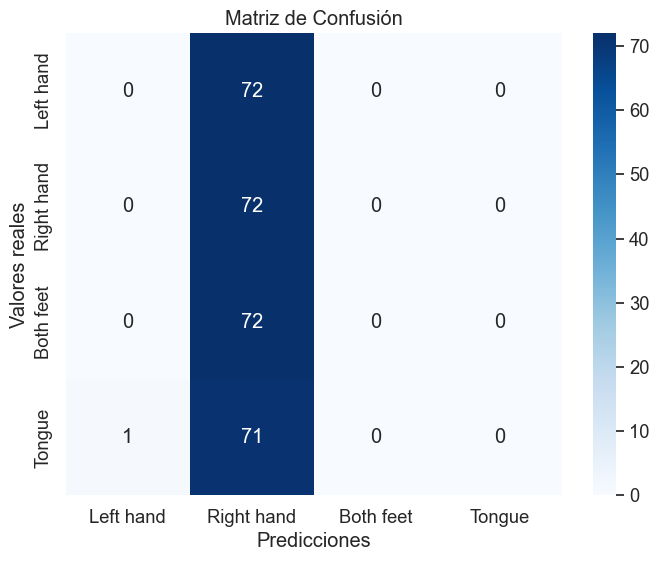

In [25]:
# load model weights
SpectralTrans.load_weights(checkpoint_filepath)
y_pred = SpectralTrans.predict(X_test_psd)
evaluate_classification_metrics(y_test_onehot, y_pred)


##### *Benchmarks*

Ahora, vamos a ver los resultados obtenidos por el modelo del estado del arte ATCNet. Como ya mencionamos anteriormente, este modelo está implementado en el archivo *models.py*

In [8]:
# Definir el ID del sujeto y la ruta de los datos
subject_number = 2
data_path = './BCI Competition IV-2a/'

In [9]:
# Obtener los datos de entrenamiento y prueba
X_train, _, y_train_onehot, X_test, _, y_test_onehot = get_BCI_competition_data(data_path, subject_number, isStandard=True)
X_train = X_train[:, np.newaxis, :, :]
X_test = X_test[:, np.newaxis, :, :]


X_train Shape: (288, 1, 22, 1125)
X_test Shape: (288, 1, 22, 1125)


In [11]:
ATCNet_model = create_ATCNet()    

In [12]:
ATCNet_model.compile(loss=categorical_crossentropy, 
                     optimizer=Adam(learning_rate=0.0009), 
                     metrics=['accuracy'])  

In [13]:
ATCNet_model.fit(X_train, 
                y_train_onehot, 
                validation_data=(X_test, y_test_onehot), 
                epochs=1, 
                batch_size=64)

5/5 [==============================] - 28s 1s/step - loss: 1.7509 - accuracy: 0.2847 - val_loss: 1.3764 - val_accuracy: 0.3438


9/9 [==============================] - 4s 154ms/step
Accuracy: 0.34375
Precision: 0.3677516048596743
Recall: 0.34375
F1 Score: 0.3208406103251463


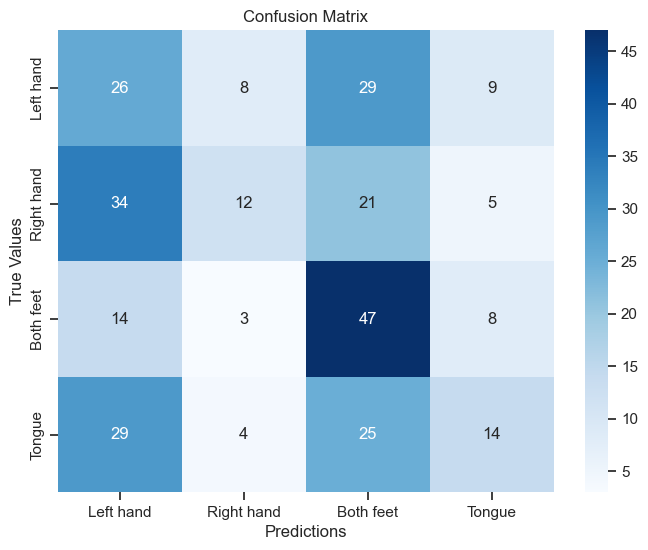

In [15]:
y_pred = ATCNet_model.predict(X_test)
evaluate_classification_metrics(y_test_onehot, y_pred)

Podemos ver que nuestro modelo no llega a ser tan bueno como la ATCNet. Esto se debe en parte a un motivo. Una señal se puede representar en dos dominios diferentes. O bien en el dominio del tiempo o bien en el dominio de la frecuencia. En este caso, hemos implementado el transformer espectral, que solo opera en el dominio de la frecuencia de la señal. En el paper original, se implementaba un *ensemble* de un tranformer espectral y un transformer temporal para recoger la información de ambos dominios. En el caso de la ATCNet ya tiene presente en la arquitectura una capa que recoge la información temporal. Es por ello, que al solo recoger información del dominio de la frecuencia con el transformer temporal, nos estemos dejando información relevante en el dominio del tiempo.

### Fine-Tuning

Finalmente, luego de haber desarrollado el Transformer Espectral y haberlo comparado con un modelo del estado del arte para poder comprobar su rendimiento, pasaremos a estudiar la viabilidad de usar este modelo para poder clasificar las señales en los sujetos con alto grado de incertidumbre debido a la cohesión de los datos. Como estamos en un entorno con escasos datos, primero realizaremos un entrenamiento general con los datos de todos los sujetos simultaneamente. De esta forma, intentamos que el modelo aprenda una representación general de los datos EEG. Una vez el modelo ha aprendido la representación de los datos de manera general, haremos que aprenda las características para un sujeto en concreto y se especialice.

**Nota:** A pesar de que entrenamos el modelo con todos los datos, no tenemos forma posible de verificar que el modelo ha aprendido la representación general de los datos, dado que los datos de un sujeto a otro son bastante diferentes entre sí. Esperamos que el modelo sea capaz de aprender, aunque sea en menor grado, la distribución general que suelen seguir los datos en las señales EEG. 

In [27]:
# Cargamos los datos estandarizados
X_train_reshaped_std, y_train, X_test_reshaped_std, y_test = split_eeg_data(standardize=True)
X_train_psd = np.transpose(calculate_psd(X_train_reshaped_std), (0, 2, 1))
X_test_psd = np.transpose(calculate_psd(X_test_reshaped_std), (0, 2, 1))
y_train_onehot = np.eye(2)[y_train]
y_test_onehot = np.eye(2)[y_test]

100%|██████████| 475/475 [00:06<00:00, 71.98it/s]


In [28]:
# Obtener las dimensiones de los datos PSD
n_samples = X_train_psd.shape[1]
n_channels = X_train_psd.shape[2]

In [29]:
SpectralTransformer = create_spectral_transformer_model(n_samples, n_channels, num_stacked_transformers=1)
SpectralTransformer.compile(loss='categorical_crossentropy', optimizer=Adam(learning_rate=0.0009), metrics=['accuracy'])  
# Entrenar el modelo
SpectralTransformer.fit(X_train_psd,  # Datos de entrenamiento
                        y_train_onehot,        # Etiquetas de entrenamiento
                        epochs=1,            # Número de épocas de entrenamiento
                        batch_size=32,         # Tamaño del lote
                        validation_data=(X_test_psd, y_test_onehot))  # Datos de validación


134/134 [==============================] - 49s 347ms/step - loss: 1.4584 - accuracy: 0.5000 - val_loss: 1.3564 - val_accuracy: 0.5432


In [30]:
id_bad_subject = 20

In [31]:
epochs_train, all_labels = extract_motor_imagery_data(id_bad_subject)
all_data = epochs_train.get_data()

In [32]:
# Reshape the data for standardization
flattened_data = all_data.reshape((-1, 161))

# Calculate mean and standard deviation along the rows
mean_values = np.mean(flattened_data, axis=0)
std_values = np.std(flattened_data, axis=0)

# Apply z-score standardization
standardized_data = (flattened_data - mean_values) / std_values

# Reshape back to the original shape
all_data = standardized_data.reshape(all_data.shape)

In [33]:
# Reshape the data to have shape (4747, -1)
all_data_reshaped = all_data.reshape((all_data.shape[0], -1))

# Split into training and testing sets
X_train_reshaped, X_test_reshaped, y_train, y_test = train_test_split(
    all_data_reshaped, all_labels, test_size=0.1, random_state=42
    )

# Reshape de X_train y X_test al formato original
X_train_reshaped_std = X_train_reshaped.reshape((X_train_reshaped.shape[0], 64, 161))
X_test_reshaped_std = X_test_reshaped.reshape((X_test_reshaped.shape[0], 64, 161))


In [34]:
X_train_psd = np.transpose(calculate_psd(X_train_reshaped_std), (0, 2, 1))
X_test_psd = np.transpose(calculate_psd(X_test_reshaped_std), (0, 2, 1))
y_train_onehot = np.eye(2)[y_train]
y_test_onehot = np.eye(2)[y_test]

100%|██████████| 5/5 [00:00<00:00, 69.41it/s]


In [35]:
# Obtener las dimensiones de los datos PSD
n_samples = X_train_psd.shape[1]
n_channels = X_train_psd.shape[2]

In [36]:
SpectralTransformer.compile(loss='categorical_crossentropy', 
                            optimizer=Adam(learning_rate=0.001), 
                            metrics=['accuracy'])  
SpectralTransformer.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 129, 64)]         0         
                                                                 
 spectral_transformer_1 (Spe  (None, 2)                290722    
 ctralTransformer)                                               
                                                                 
Total params: 290,722
Trainable params: 290,722
Non-trainable params: 0
_________________________________________________________________


In [40]:
SpectralTransformer.fit(X_train_psd, y_train_onehot, 
                        validation_data=(X_test_psd, y_test_onehot), 
                        epochs=5,
                        batch_size=32)

Epoch 1/5


2/2 [==============================] - 0s 184ms/step - loss: 1.2345 - accuracy: 0.6500 - val_loss: 1.2754 - val_accuracy: 0.6000
Epoch 2/5
2/2 [==============================] - 0s 153ms/step - loss: 1.2161 - accuracy: 0.7000 - val_loss: 1.2644 - val_accuracy: 0.8000
Epoch 3/5
2/2 [==============================] - 0s 155ms/step - loss: 1.1939 - accuracy: 0.8500 - val_loss: 1.2602 - val_accuracy: 0.8000
Epoch 4/5
2/2 [==============================] - 1s 169ms/step - loss: 1.1546 - accuracy: 0.8000 - val_loss: 1.2803 - val_accuracy: 0.6000
Epoch 5/5
2/2 [==============================] - 1s 159ms/step - loss: 1.1373 - accuracy: 0.7000 - val_loss: 1.2348 - val_accuracy: 0.8000


In [41]:
y_pred = SpectralTransformer.predict(X_test_psd)
evaluate_classification_metrics(y_test_onehot, y_pred, class_labels=['Hands', 'Feets'])

1/1 [==============================] - 0s 348ms/step
Accuracy: 0.8
Precision: 0.8666666666666666
Recall: 0.8
F1 Score: 0.8
Confusion Matrix:
[[2 0]
 [1 2]]


### Conclusión
AÑADIR CONCLUSION